<a href="https://colab.research.google.com/github/shuodeng521-sys/ST-554-Project1-Shuo-Anna-Jillian/blob/main/Shuo_Project1_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1_Task 3
Shuo Deng


#Introduction
Monitoring carcinogenic air pollutants is important for protecting public health, but high‑quality sensing equipment is often expensive and difficult to deploy widely. Prior work by De Vito et al. (2008) suggests that low‑cost gas sensors may be calibrated using statistical models to approximate true pollutant concentrations.

In this task, I focus on modeling the true benzene concentration C6H6 (GT) using simple and multiple linear regression. The goal is to evaluate how well sensor and weather variables can predict benzene levels, and to compare model performance using a rolling one‑step‑ahead cross‑validation approach.

###Data read in

In [7]:
# Install UCI package - only needs to be done 1st time
!pip install ucimlrepo

In [28]:
# Import auxillary packages for Task 3
import pandas as pd
import ucimlrepo as uci
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Fetch the Air Quality Multisensor dataset
air_quality = uci.fetch_ucirepo(id=360)

In [10]:
# Print var info
air_quality.variables

,name,role,type,demographic,description,units,missing_values
0,Date,Feature,Date,None,None,None,no
1,Time,Feature,Categorical,None,None,None,no
2,CO(GT),Feature,Integer,None,True hourly averaged concentration CO in mg/m^...,mg/m^3,no
3,PT08.S1(CO),Feature,Categorical,None,hourly averaged sensor response (nominally CO...,None,no
4,NMHC(GT),Feature,Integer,None,True hourly averaged overall Non Metanic Hydro...,microg/m^3,no
5,C6H6(GT),Feature,Continuous,None,True hourly averaged Benzene concentration in...,microg/m^3,no
6,PT08.S2(NMHC),Feature,Categorical,None,hourly averaged sensor response (nominally NMH...,None,no
7,NOx(GT),Feature,Integer,None,True hourly averaged NOx concentration in ppb...,ppb,no
8,PT08.S3(NOx),Feature,Categorical,None,hourly averaged sensor response (nominally NOx...,None,no
9,NO2(GT),Feature,Integer,None,True hourly averaged NO2 concentration in micr...,microg/m^3,no


In this Task, we will use the following variables: Date, CO(GT), C6H6(GT),T,RH	,AH

In [11]:
air = air_quality.data.features # extract the features (X variables) from the UCI dataset

In [12]:
# display the first 5 rows of the DataFrame
air.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


###Data Cleaning

In [13]:
#change column name
air=air.rename(columns={"CO(GT)": "CO_GT", "C6H6(GT)": "C6H6_GT"})

In [14]:
# Replace placeholder missing values (-200) with actual NaN values
cols=["C6H6_GT","CO_GT","T","RH","AH"]
air_temp=air.replace(-200,pd.NA)
air_sub=air_temp.dropna(subset=cols)
# Check how many missing values
air_temp.shape, air_sub.shape

((9357, 15), (7344, 15))

In [15]:
# Select the variables to reduce compute time
cols = ["Date", "C6H6_GT", "CO_GT", "T", "RH", "AH"]
air_sub = air_sub[cols]
# Convert Date to datetime
air_sub["Date"] = pd.to_datetime(air_sub["Date"])
# Compute daily averages
air_daily = air_sub.groupby("Date").mean().reset_index()
#add new variable"Day"
air_daily["Day"] = range(1, len(air_daily) + 1)
#check how many days in total
air_daily.tail()

,Date,C6H6_GT,CO_GT,T,RH,AH,Day
342,2005-03-31,5.220833,1.3875,17.55,50.083333,0.951917,343
343,2005-04-01,3.526087,1.108696,16.026087,35.404348,0.631135,344
344,2005-04-02,2.529167,0.854167,15.483333,32.225,0.546167,345
345,2005-04-03,4.316667,1.141667,18.383333,33.695833,0.617583,346
346,2005-04-04,8.985714,2.078571,17.328571,41.842857,0.72125,347


##Model validation

In [22]:
#Create a function to caculate the one-step-ahead MSE
from sklearn.metrics import mean_squared_error
def one_step_mse(x,y,day):
  """
  Calculate the one-step-ahead prediction MSE for a given day.
  Parameters:
  x   : DataFrame of predictor variables
  y   : Series of response variable
  day : integer index representing the last day included in the training set
  Returns:
  MSE for predicting day+1 using data from day 0 through 'day'
  """
  # Training data: use days 0 through 'day'
  x_train=x.iloc[:day+1]
  y_train=y.iloc[:day+1]
  # Test data: predict for day+1 only
  x_test=x.iloc[day+1:day+2]
  y_test=y.iloc[day+1:day+2]
  # Fit linear regression REG3
  reg3=sklearn.linear_model.LinearRegression()
  reg3.fit(x_train,y_train)
  # Make prediction for day+1
  pred3=reg3.predict(x_test)
  return mean_squared_error(y_test.values,pred3)


In [17]:
#Create a funtion to caclate rolling (sequential) cross-validation MSE
def rolling_cv(x,y,start_day=250):
  """
  Perform rolling (time-series) cross-validation and compute the average MSE.
  Parameters:
    x         : DataFrame of predictor variables
    y         : Series of response variable
    start_day : the first day to begin prediction (default = 250)
  Returns:
    The average MSE across all one-step-ahead predictions.
  """
  mse_list=[]
  for day in range(start_day,len(x)-1):
      mse=one_step_mse(x,y,day)
      mse_list.append(mse)
  return sum(mse_list)/len(mse_list)

In [18]:
#Use the rolling_cv function to caculate SLR average MSE
x_slr = air_daily[['CO_GT']]
y = air_daily['C6H6_GT']
slr_mse=rolling_cv(x_slr,y)
print("SLR average MSE",slr_mse)

SLR average MSE 7.368868881483631


In [25]:
#Use the rolling_cv function to caculate MLR average MSE
x_mlr=air_daily[['CO_GT', 'T', 'RH', 'AH']]
y=air_daily["C6H6_GT"]
mlr_mse=rolling_cv(x_mlr,y)
print("MLR average MSE",mlr_mse)

MLR average MSE 5.132396547486296


#Conclusion:
the MLR model has the smaller average MSE (5.13<7.37), meaning it predicts future C6H6_GT more accurately than the SLR model.

In [34]:
#fit the ‘best’ model to the entire data set
model = sklearn.linear_model.LinearRegression()
model.fit(air_daily[['CO_GT', 'T', 'RH', 'AH']], air_daily['C6H6_GT'])
print("Best model intercept:", model.intercept_)
print("Best model coefficients:", model.coef_)

Best model intercept: -1.8377694729981808
Best model coefficients: [ 4.77080433  0.11973259 -0.01620259  0.68866811]


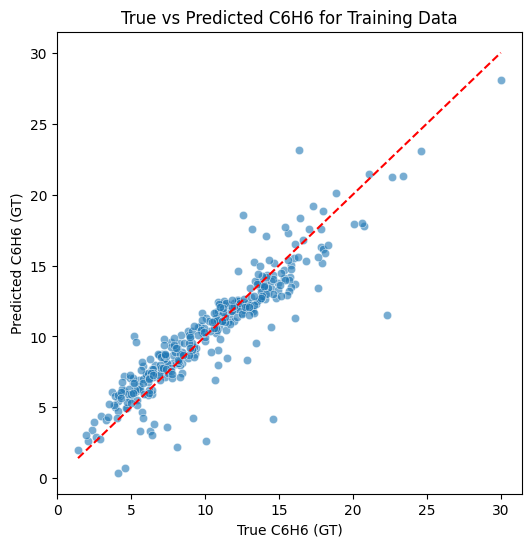

In [33]:
# Scatterplot of true vs predicted C6H6 for the training data
# Fit the final MLR model on the full dataset
reg4=sklearn.linear_model.LinearRegression()
reg4.fit(x_mlr, y)
# Generate predictions for the full dataset
y_pred_full = reg4.predict(x_mlr)
# Create a scatterplot comparing true vs predicted C6H6 values
plt.figure(figsize=(6,6))
sns.scatterplot(x=y, y=y_pred_full, alpha=0.6)
# Add a 45-degree reference line representing perfect predictions
plt.plot([y.min(), y.max()],
         [y.min(), y.max()], color='red', linestyle='--')
# Label the axes and add a title
plt.xlabel("True C6H6 (GT)")
plt.ylabel("Predicted C6H6 (GT)")
plt.title("True vs Predicted C6H6 for Training Data")
plt.show()

Overall, the model’s predictions line up reasonably well with the true C6H6 values, as most points fall close to the 45‑degree reference line. Although there is some spread—especially at higher concentrations—the model captures the main trend and provides a stable baseline fit for the training data.

#Extra work: using a differnt method to calculate MSE

In [34]:
#Caculate SLR MSE (loop method)
from sklearn.metrics import mean_squared_error
mse_list_slr=[]
for i in range(250,len(air_daily)):
    train=air_daily.iloc[:i]
    test=air_daily.iloc[i:i+1]
    x_train=train["CO_GT"].values.reshape(-1,1)
    y_train=train["C6H6_GT"]
    x_test=test["CO_GT"].values.reshape(-1,1)
    y_test=test["C6H6_GT"]
    reg1=sklearn.linear_model.LinearRegression()
    reg1.fit(x_train,y_train)
    pred1=reg1.predict(x_test)
    mse_list_slr.append(mean_squared_error(y_test.values,pred1))
slr_mse=sum(mse_list_slr)/len(mse_list_slr)
print('SLR MSE:', slr_mse)

SLR MSE: 7.402897202768712


In [35]:
#Caculate MLR MSE (loop method)
mse_list_mlr=[]
for i in range(250,len(air_daily)):
    train=air_daily.iloc[:i]
    test=air_daily.iloc[i:i+1]
    x_train=train[['CO_GT', 'T', 'RH', 'AH']]
    y_train=train["C6H6_GT"]
    x_test=test[['CO_GT', 'T', 'RH', 'AH']]
    y_test=test["C6H6_GT"]
    reg2=sklearn.linear_model.LinearRegression()
    reg2.fit(x_train,y_train)
    pred2=reg2.predict(x_test)
    mse_list_mlr.append(mean_squared_error(y_test.values,pred2))
mlr_mse=sum(mse_list_mlr)/len(mse_list_mlr)
print('MLR MSE:',mlr_mse)

MLR MSE: 5.096311564583979
